# Quadratic Programming

Suppose we want to minimize the Euclidean distance of the solution to the origin while subject to linear constraints. This will require a quadratic objective function. Consider this example problem:

> **min** $\frac{1}{2}\left(x^2 + y^2 \right)$

> *subject to*

> $x + y = 2$

> $x \ge 0$

> $y \ge 0$

This problem can be visualized graphically:

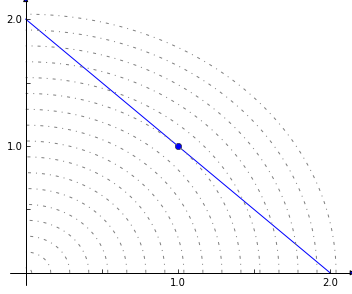

In [1]:
%matplotlib inline
from matplotlib.pyplot import figure, xlim, ylim
from mpl_toolkits.axes_grid.axislines import SubplotZero
from numpy import linspace, arange, sqrt, pi, sin, cos, sign
# axis style
def make_plot_ax():
    fig = figure(figsize=(6, 5));
    ax = SubplotZero(fig, 111); fig.add_subplot(ax)
    for direction in ["xzero", "yzero"]:
        ax.axis[direction].set_axisline_style("-|>")
        ax.axis[direction].set_visible(True)
    for direction in ["left", "right", "bottom", "top"]:
        ax.axis[direction].set_visible(False)
    xlim(-0.1, 2.1); ylim(xlim())
    ticks = [0.5 * i for i in range(1, 5)]
    labels = [str(i) if i == int(i) else "" for i in ticks]
    ax.set_xticks(ticks); ax.set_yticks(ticks)
    ax.set_xticklabels(labels); ax.set_yticklabels(labels)
    ax.axis["yzero"].set_axis_direction("left")
    return ax
    
ax = make_plot_ax()
ax.plot((0, 2), (2, 0), 'b')
ax.plot([1], [1], 'bo')

# circular grid
for r in sqrt(2.) + 0.125 * arange(-11, 6):
    t = linspace(0., pi/2., 100)
    ax.plot(r * cos(t), r * sin(t), '-.', color="gray")

The objective can be rewritten as $\frac{1}{2} v^T \cdot \mathbf Q \cdot v$, where
$v = \left(\begin{matrix} x \\ y\end{matrix} \right)$ and
$\mathbf Q = \left(\begin{matrix} 1 & 0\\ 0 & 1 \end{matrix}\right)$

The matrix $\mathbf Q$ can be passed into a cobra model as the quadratic objective.

In [2]:
import scipy

from cobra import Reaction, Metabolite, Model, solvers

The quadratic objective $\mathbf Q$ should be formatted as a scipy sparse matrix.

In [3]:
Q = scipy.sparse.eye(2).todok()
Q

<2x2 sparse matrix of type '<type 'numpy.float64'>'
	with 2 stored elements in Dictionary Of Keys format>

In this case, the quadratic objective is simply the identity matrix

In [4]:
Q.todense()

matrix([[ 1.,  0.],
        [ 0.,  1.]])

We need to use a solver that supports quadratic programming, such as gurobi or cplex. If a solver which supports quadratic programming is installed, this function will return its name.

In [5]:
print(solvers.get_solver_name(qp=True))

gurobi


In [6]:
c = Metabolite("c")
c._bound = 2
x = Reaction("x")
y = Reaction("y")
x.add_metabolites({c: 1})
y.add_metabolites({c: 1})
m = Model()
m.add_reactions([x, y])
sol = m.optimize(quadratic_component=Q, objective_sense="minimize")
sol.x_dict

{'x': 1.0, 'y': 1.0}

Suppose we change the problem to have a mixed linear and quadratic objective.

> **min** $\frac{1}{2}\left(x^2 + y^2 \right) - y$

> *subject to*

> $x + y = 2$

> $x \ge 0$

> $y \ge 0$

Graphically, this would be

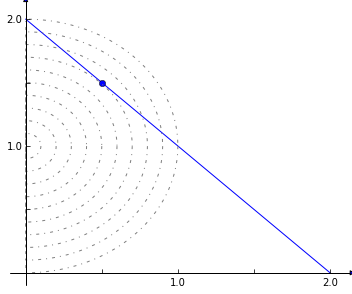

In [7]:
ax = make_plot_ax()
ax.plot((0, 2), (2, 0), 'b')
ax.plot([0.5], [1.5], 'bo')

yrange = linspace(1, 2, 11)
for r in (yrange ** 2 / 2. - yrange):
    t = linspace(-sqrt(2 * r + 1) + 0.000001, sqrt(2 * r + 1) - 0.000001, 1000)
    ax.plot(abs(t), 1 + sqrt(2 * r + 1 - t ** 2) * sign(t), '-.', color="gray")

QP solvers in cobrapy will combine linear and quadratic coefficients. The linear portion will be obtained from the same objective_coefficient attribute used with LP's.

In [8]:
y.objective_coefficient = -1
sol = m.optimize(quadratic_component=Q, objective_sense="minimize")
sol.x_dict

{'x': 0.5, 'y': 1.5}